In [1]:
# for reading in lists of files in folders 
from os import listdir 
from os.path import isfile, join

# for working with numpy functionalities
import numpy as np

# for plotting with matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# for mathematical operations
import math 

# for interpolating points
from scipy.interpolate import interp1d 

# for Procrustes analysis
from scipy.spatial import procrustes #

# for principal component analysis
from sklearn.decomposition import PCA 

# for dataframe capabilities
import pandas as pd

# for hue and other plotting capabilities
import seaborn as sns

/Users/chitwood/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


### Read in shape data, landmark data, and get shape names

In [2]:
########################################################################
# 1. retreive file names in shape and landmark folders
# 2. make sure they are alphanumerically sorted so their indices correspond
# 3. create a list of just shape names derived from the shape file names
# 4. read in data and create a list of arrays of a) shape data and b) landmark data

######################################################
# 1. retreive file names in shape and landmark folders
# 2. make sure they are alphanumerically sorted so their indices correspond

# provide path to shapes folder
shapes_path = "./1_shapes"

# provide path to landmarks folder
landmarks_path = "./2_landmarks"

# retrieve a list of shape file names
shape_files = [f for f in listdir(shapes_path) if isfile(join(shapes_path, f))] 
# sort the file names alphanumerically so they correspond to landmark files
shape_files.sort()

#retrieve a list of landmark file names
landmark_files = [f for f in listdir(landmarks_path) if isfile(join(landmarks_path, f))] 
# sort the file names alphanumerically so they correspond to shape files
landmark_files.sort()

########################################################################
# 3. create a list of just shape names derived from the shape file names

# create a list to store names
shapes = []

# for each shape file
for i in range(len(shape_files)):
    
    # index the current file name, and index the first two characters and append to the shapes list
    shapes.append(shape_files[i][0:2])

###################################################################################
# 4. read in data and create a list of arrays of a) shape data and b) landmark data    

# a list of arrays, to store 2D arrays of shape data points for each shape
shape_data = []

# a list of arrays, to store 2D arrays of landmark points for each shape
landmark_data = []

# for each shape
for i in range(len(shapes)):
    
    # load in the shape data as a 2D numpy array
    current_shape_data = np.loadtxt("./1_shapes/" + shape_files[i])
    # append the 2D array to the shape_data list
    shape_data.append(current_shape_data)
    
    # load in the landmark data as a 2D numpy array
    current_landmark_data = np.loadtxt("./2_landmarks/" + landmark_files[i])
    # append the 2D array to the landmark_data list
    landmark_data.append(current_landmark_data)


### Find the indices of the points in the shape data that correspond to the base and tip landmarks

In [3]:
##################################################################################################
# we need to find the points in the shape data file that are closest to the base and tip landmarks
# 1. calculate the euclidean distance of each shape data point to the base and tip landmark
# and store the indices of the shape points, so we know which shape data points to use as landmarks
# 2. use indices to plot out base and tip landmarks and make sure we were successful

###########################################################################################
# 1. calculate the euclidean distance of each shape data point to the base and tip landmark
# and store the indices of the shape points, so we know which shape data points to use as landmarks

# a list of lists,
# to store the indices of the points in the shape file closest to the base and tip landmarks
# for each shape
landmark_indices = []

# for each shape
for i in range(len(shapes)):
    
    # select data points in array for the current shape
    current_shape = shape_data[i]
    
    # select landmark points in array for the current shape
    current_landmarks = landmark_data[i]
    
    # create a list to store the distance of each shape point to the base landmark
    base_distances = []
    # create a list to store the distance of each shape point to the tip landmark
    tip_distances = []
    
    # for the number of points in the shape_data file
    # use np.shape, with "0" to count number of rows, or points in the data
    for j in range(np.shape(current_shape)[0]):
        
        # calculate the euclidean distance of each shape point to
        # the base landmark and append to the base distance list
        base_distances.append(np.sqrt(
            (current_landmarks[0,0]-current_shape[j,0])**2 + 
            (current_landmarks[0,1]-current_shape[j,1])**2))
        
        # calculate the euclidean distance of each shape point to
        # the tip landmark and append to the tipdistance list
        tip_distances.append(np.sqrt(
            (current_landmarks[1,0]-current_shape[j,0])**2 + 
            (current_landmarks[1,1]-current_shape[j,1])**2))
    
    # find the indices of the minimum distance of the base and tip to shape points
    # append a list of the base and tip minimum indices to the list landmark indices
    landmark_indices.append([base_distances.index(min(base_distances)),
               tip_distances.index(min(tip_distances))])

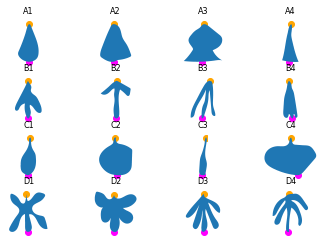

In [4]:
####################################################################################
# 2. use indices to plot out base and tip landmarks and make sure we were successful

# for each shape
for i in range(len(shapes)):
    
    # get current plot number for plt.subplot, + 1 because indexing starts at 0
    plot_num = i + 1 
    
    # select data points for the current shape
    current_shape = shape_data[i]
    
    # specify subplot
    plt.subplot(4,4,plot_num) 
    
    # plot shape name above each shape (need to modify so no overlap still)
    plt.title(shapes[i], fontsize=8) 
    
    # use fill to plot each shape, index on the columns of the arrays for x and y coords
    plt.fill(current_shape[:,0], current_shape[:,1])
    
    # use the landmark indices to plot the base landmark in orange
    # the ith index in landmark_indices indicates the index of the shape data point corresponding to base
    plt.scatter(current_shape[landmark_indices[i][0],0], current_shape[landmark_indices[i][0],1], c="orange")
    
    # use the landmark indices to plot the tip landmark in magenta
    # the ith index in landmark_indices indicates the index of the shape data point corresponding to tip
    plt.scatter(current_shape[landmark_indices[i][1],0], current_shape[landmark_indices[i][1],1], c="magenta")
    
    # set axes equal in scale and turn off display axes
    plt.gca().set_aspect("equal")
    plt.axis("off")

### Reindex the coordinate values so that they begin with the base at index = 0

In [5]:
############################################################################
# The problem is that the base landmark doesn't start at index position 0
# the base is at an arbitrary index value, and the zero index is also
# at an arbitrary position in the shape. We need to reindex to the base being index = 0
# 1. Reindex the shape data
# 2. Reindex the landmark data

############################
# 1. Reindex the shape data

# a list of arrays, with a 2D array of reindexed x and y coordinates for each shape
reindexed_data = []

# for each shape, s
for s in range(len(shapes)):
    
    # get number of coordinate values for the current shape
    num_coords = np.shape(shape_data[s])[0] 
    
    # get the zeroth index to start at (the base)
    zero_index = landmark_indices[s][0] 

    # create an array to store new x and y vals using np.zeros
    reindexed_arr = np.zeros((num_coords,2)) 

    # for the number of points in the shape, i
    for i in range(num_coords):

        # get current index
        curr_ind = i 
        
        # get the new index to use
        new_ind = (i - zero_index)%num_coords 
        
        # store the value at the new index position
        reindexed_arr[new_ind,:] = shape_data[s][curr_ind,:] 
        
    # append the reindexed array into the shape_data list
    reindexed_data.append(reindexed_arr)


In [6]:
##############################
# 2. Reindex the landmark data

# a list of lists, with lists of indices for each shape
reindexed_indices = []

# for each shape, s
for s in range(len(shapes)):
    
    # get number of coordinate values
    num_coords = np.shape(shape_data[s])[0] 
    
    # get the zeroth, base index
    zero_index = landmark_indices[s][0]
    
    # get the tip index
    tip_index = landmark_indices[s][1]
    
    # get the new base index (it should be 0 in all cases, by definition)
    new_base = (zero_index - zero_index)%num_coords
    
    # get the new tip index
    new_tip = (tip_index - zero_index)%num_coords
    
    # create new indices list
    new_indices = [new_base, new_tip]
        
    # append the reindexed indices into the reindexed_indices list
    reindexed_indices.append(new_indices)
    

### Rotate shapes to the same angle

In [7]:
####################################################
# We want to rotate all the shapes to the same angle
# Procrustes analysis will take care of rotation
# however, when we reconstruct the leaves, we want them at
# an angle we have chosen, not an arbitrary one
# so we rotate the data before we do Procrustes alignment

#####################################################################
# 1. Using tip and base landmarks, rotate leaves to the desired angle
# 2. Plot out leaves and check that we were successful

###########
# FUNCTIONS
###########

# define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
# and p1 being the left hand of the angle and p3 a reference point for directionality
# inputs: three angle points, as tuples
# output: angle in degrees

def angle_between(p1, p2, p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

# define a function to rotate 2D x and y coordinate points around the origin
# inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
# target_angle is the angle you want to rotate to, in degrees
# outputs: rotated and y vals

def rotate_points(xvals, yvals, degrees, target_angle):
    
    angle_to_move = target_angle - degrees 
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

#####################################################################
# 1. Using tip and base landmarks, rotate leaves to the desired angle

#################
# set the angle to rotate to in degrees
target_angle = 90
#################

# a list of arrays, a list of 2D arrays containing the rotated x and y coordinates for each shape
rotated_data = [] 

# for the number of shapes
for i in range(len(shapes)):

    # the left hand of the angle, the point that determines the angle, the tip in this case
    determining_point = reindexed_data[i][reindexed_indices[i][1],:] 
    # the vertex of the angle, the point the angle rotates around, the base in this case
    origin_point = reindexed_data[i][reindexed_indices[i][0],:] 
    # the reference side of the angle that determines direction, 
    # we use the base but shift the x value positively in our case
    reference_point = (reindexed_data[i][reindexed_indices[i][0],0]+1,reindexed_data[i][reindexed_indices[i][0],1])

    # using the three calculated points above, calculate the angle in degrees
    angle = angle_between(determining_point, origin_point, reference_point) # calculate current angle

    # use the rotate_points function to rotate the points to the desired new angle
    rotated_xvals, rotated_yvals = rotate_points(reindexed_data[i][:,0], reindexed_data[i][:,1], angle, target_angle)

    # put the x and y coordiantes back together again as a 2D numpy array
    rotated_coords = np.column_stack((rotated_xvals, rotated_yvals))
    
    # append the rotated 2D coordinates for the current shape to the list
    rotated_data.append(rotated_coords)
    

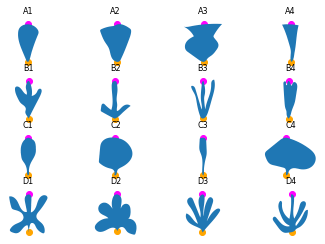

In [8]:
######################################################
# 2. Plot out leaves and check that we were successful

# for each shape
for i in range(len(shapes)):
    
    # get current plot number for plt.subplot, + 1 because indexing starts at 0
    plot_num = i + 1 
    
    # select data points for the current shape
    current_shape = rotated_data[i]
    
    # specify subplot
    plt.subplot(4,4,plot_num) 
    
    # plot shape name above each shape (need to modify so no overlap still)
    plt.title(shapes[i], fontsize=8) 
    
    # use fill to plot each shape, index on the columns of the arrays for x and y coords
    plt.fill(current_shape[:,0], current_shape[:,1])
    
    # use the landmark indices to plot the base landmark in orange
    # the ith index in landmark_indices indicates the index of the shape data point corresponding to base
    plt.scatter(current_shape[reindexed_indices[i][0],0], current_shape[reindexed_indices[i][0],1], c="orange")
    
    # use the landmark indices to plot the tip landmark in magenta
    # the ith index in landmark_indices indicates the index of the shape data point corresponding to tip
    plt.scatter(current_shape[reindexed_indices[i][1],0], current_shape[reindexed_indices[i][1],1], c="magenta")
    
    # set axes equal in scale and turn off display axes
    plt.gca().set_aspect("equal")
    plt.axis("off")

### Use interpolation to create pseudolandmarks

In [9]:
########################################################################################
# 1. before we do Procrustes analysis, we need to create the same number of interpolated
# points that correspond with each other between the tip and the base on each side of the leaf
# 2. Check that the interpolation was done correctly

##########
# FUNCTION
##########

# define a function to return equally spaced, interpolated points for a given polyline
# inputs: arrays of x and y values for a polyline, number of points to interpolate
# ouputs: interpolated points along the polyline, inclusive of start and end points, as arrays

def interpolation(x, y, number): 

    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

########################################################################################
# 1. before we do Procrustes analysis, we need to create the same number of interpolated
# points that correspond with each other between the tip and the base on each side of the leaf

#################
# set the number of points to interpolate on EACH SIDE of the leaf (total point number will be double)
point_number = 100
#################

# a list of arrays, a list of 2D arrays containing the interpolated x and y coordinates for each shape
interpolated_data = [] 

for i in range(len(shapes)):

    # interpolate between the base to the point before the tip for the given point number
    base_to_tip_x, base_to_tip_y = interpolation(rotated_data[i][reindexed_indices[i][0]:(reindexed_indices[i][1])-1,0], 
                                         rotated_data[i][reindexed_indices[i][0]:(reindexed_indices[i][1])-1,1], 
                                         point_number)

    # interpolate between the tip to the last point for the given point number
    tip_to_base_x, tip_to_base_y = interpolation(rotated_data[i][reindexed_indices[i][1]:,0], 
                                         rotated_data[i][reindexed_indices[i][1]:,1], 
                                         point_number)


    # combine each set of points into 2D numpy arrays of x and y coordinates
    base_to_tip_coords = np.column_stack((base_to_tip_x, base_to_tip_y))
    tip_to_base_coords = np.column_stack((tip_to_base_x, tip_to_base_y))

    # combine both sets of points into a single 2D array for the overall shape
    interpolated_coords = np.row_stack((base_to_tip_coords, tip_to_base_coords))
    
    # append the array of interpolated points to the list
    interpolated_data.append(interpolated_coords)


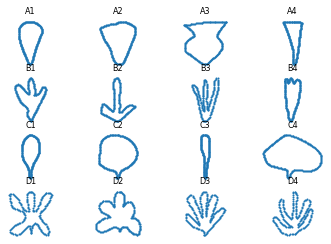

In [10]:
####################################################
# 2. Check that the interpolation was done correctly

# for each shape
for i in range(len(shapes)):
    
    # get current plot number for plt.subplot, + 1 because indexing starts at 0
    plot_num = i + 1 
    
    # select data points for the current shape
    current_shape = interpolated_data[i]
    
    # specify subplot
    plt.subplot(4,4,plot_num) 
    
    # plot shape name above each shape (need to modify so no overlap still)
    plt.title(shapes[i], fontsize=8) 
    
    # use scatter to check interpolated points
    plt.scatter(current_shape[:,0], current_shape[:,1], s=1)
    
    # set axes equal in scale and turn off display axes
    plt.gca().set_aspect("equal")
    plt.axis("off")

### Calculate mean Generalized Procrustes Analysis (GPA) shape

Procrustes analysis aligns two shapes to each other by minimizing their overall distance. This Procrustes distance can be used as a measure of how similar to shapes are to each other. When aligning many shapes to each other as we are doing here, we need to find an overall mean leaf to align all leaves to. The algorithm to calculate this mean leaf for many leaves is called Generalized Procrustes Analysis (GPA). The GPA algorithm works by starting with an arbitrary reference leaf, usually the first sample. All leaves are aligned to the reference and a mean is calculated. This new mean leaf is then used as a new reference, again which all leaves are aligned to and a new mean is calculated which serves as the new reference. When the Procrustes distance between the new mean and the old mean reach an arbitrarily low Procrustes distance value, we use the mean as the Procrustes mean to align all the leaves to.

In [11]:
ref_ind = 0 # select a reference index to calculate procrustes distances to
ref_shape = interpolated_data[ref_ind] # select the reference shape
landmark_number = np.shape(interpolated_data[0])[0] # get number of landmarks from first shape (it's the same for all shapes)

mean_diff = 10**(-30) # set a Procrustes distance between means to stop the algorithm, arbitrarily small

old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

d = 1000000 # set d, the distance, initially arbitraily high

while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations
    
    arr = np.zeros( ((len(shapes)),landmark_number,2) ) # empty 3D array: # samples, total number of landmarks, 2 coord vals

    for i in range(len(shapes)): # for each leaf shape 

        s1, s2, distance = procrustes(old_mean, interpolated_data[i]) # calculate procrustes adjusted shape to ref for current leaf
        arr[i] = s2 # store procrustes adjusted shape to array

    new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference
    
    s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean
    
    print("the Procrustes distance between the old and new mean is", d) # print out difference between mean distance
    
    old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration
    
gpa_mean = new_mean # call the resulting mean leaf "gpa_mean"


the Procrustes distance between the old and new mean is 0.0399940960002229
the Procrustes distance between the old and new mean is 0.00020530173584061573
the Procrustes distance between the old and new mean is 1.1566573408045883e-06
the Procrustes distance between the old and new mean is 6.5704765095877785e-09
the Procrustes distance between the old and new mean is 3.739875606526043e-11
the Procrustes distance between the old and new mean is 2.1303122116583566e-13
the Procrustes distance between the old and new mean is 1.2138801292060909e-15
the Procrustes distance between the old and new mean is 6.917964215919858e-18
the Procrustes distance between the old and new mean is 3.942891318237267e-20
the Procrustes distance between the old and new mean is 2.2473255737722235e-22
the Procrustes distance between the old and new mean is 1.2811460012870875e-24
the Procrustes distance between the old and new mean is 7.310735044632243e-27
the Procrustes distance between the old and new mean is 4.33

#### Check the Generalized Procrustes Analysis mean shape

(-0.052244135755455424,
 0.05192114970123209,
 -0.09728962989696723,
 0.08941872804277146)

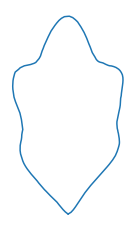

In [12]:
plt.plot(gpa_mean[:,0], gpa_mean[:,1])
plt.gca().set_aspect("equal")
plt.axis("off")


### Calculate Procrustes-adjusted coordinates for each leaf against the calculated mean

In [13]:
landmark_number = np.shape(interpolated_data[0])[0] # get number of landmarks from first shape (it's the same for all)

proc_arr = np.zeros( ((len(shapes)), landmark_number, 2) ) # empty 3D array: # samples, total landmarks, 2 coord vals

for i in range(len(shapes)): # for each leaf shape 

    s1, s2, distance = procrustes(gpa_mean, interpolated_data[i]) # calculate procrustes adjusted shape to ref for current leaf
    proc_arr[i] = s2 # store procrustes adjusted shape to array
    

#### Visually check all Procrustes adjusted leaf shapes, plot with the gpa mean leaf

(-0.09270290039608148,
 0.0971197566262207,
 -0.12624042620177398,
 0.12235204087612973)

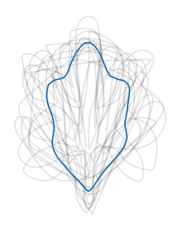

In [14]:
plot_col = "k" # set plot color
a = 0.1 # set alpha

for i in range(np.shape(proc_arr)[0]):
    
    curr_leaf = proc_arr[i,:,:]
    
    plt.plot(curr_leaf[:,0], curr_leaf[:,1], c=plot_col, alpha=a) # plot current leaf with color and alpha
    plt.gca().set_aspect("equal")
    
plt.plot(gpa_mean[:,0], gpa_mean[:,1]) # plot the mean leaf

plt.gca().set_aspect("equal")
plt.axis("off")

### Morphospace and Inverse Principal Component Analysis

#### Find percent variance for each PC

In [15]:
# get the number of samples from the list of shapes
num_samples = len(interpolated_data) 

# from the first shape, get the total number of coordinates for each shape
total_length = np.shape(interpolated_data[0])[0] 

# use the reshape function to flatten proc_arr to 2D, so that x and y coordinates are input into the PCA
reshaped_arr = proc_arr.reshape(num_samples, total_length*2) 

# set number of PCs to number of samples, so we can see the percent variance for all PCs
test_pca = PCA(n_components=num_samples)

# fit a PCA
test_PCs = test_pca.fit_transform(reshaped_arr) 

# print out explained variance for each PC (a proportion)
print(test_pca.explained_variance_ratio_) 

# print out cumulative variance explained by PC (a proportion)
print(test_pca.explained_variance_ratio_.cumsum()) 

[3.82596592e-01 2.42212886e-01 1.43816780e-01 9.45759392e-02
 4.58543628e-02 3.34777111e-02 2.57632973e-02 1.07516109e-02
 7.15718288e-03 6.18927878e-03 3.83160294e-03 1.83160516e-03
 1.31723995e-03 4.02877781e-04 2.21032443e-04 8.10941897e-32]
[0.38259659 0.62480948 0.76862626 0.8632022  0.90905656 0.94253427
 0.96829757 0.97904918 0.98620636 0.99239564 0.99622724 0.99805885
 0.99937609 0.99977897 1.         1.        ]


#### Create an inverse PCA space and calculate PC points to reconstruct

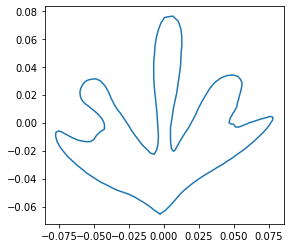

In [16]:
# define number of desired PCs
# for reconstruction, it's easier to just use 2
# but we can use more PC values if desired

pca = PCA(n_components=2)

# apply the sklearn pca function with desired number of components

PCs = pca.fit_transform(reshaped_arr)

# the inverse transform function is applied

inverse_PCA = pca.inverse_transform(PCs)

# specify PC value to reconstruct
# (this is just a test to make sure we can reconstruct 
# theoretical leaves using only PC values)

PC1_val = 0.5
PC2_val = 0

# perform inverse PCA
    
inv_new = pca.inverse_transform(np.array([PC1_val,PC2_val]))

# extract x and y vals, every other using the step indexing

inv_xvals = inv_new[0::2]
inv_yvals = inv_new[1::2]

# plot the theoretical, reconstructed shape
plt.plot(inv_xvals, inv_yvals)
plt.gca().set_aspect("equal")

### Plot background morphospace  

To reduce the amount of code we are using, we will create a function to plot out a background morphospace. We can always come back to change the specifics of the function if needed.

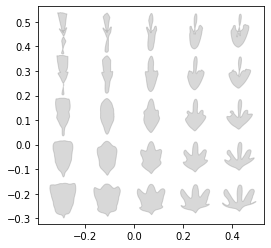

In [17]:
# scale, determined by checking, to prevent shape overlap
scale = 0.8

# padding on each side of PC to add extra space to see morphospace
PC1_pad = 0.1
PC2_pad = 0.1

# number of intervals to divide each PC axis
num_intervals = 5 

# get PC1 interval values
PC1_intervals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]) ,num_intervals)

# get PC2 interval values
PC2_intervals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), num_intervals)

for i in PC1_intervals:
    
    for j in PC2_intervals:
        
        # perform inverse PCA
    
        inv_new = pca.inverse_transform(np.array([i,j]))

        # extract x and y vals, every other

        inv_PC1_vals = inv_new[0::2]
        inv_PC2_vals = inv_new[1::2]
          
        # scale so the shapes don't overlap, determine the right scale by checking
        
        scaled_PC1_vals = inv_PC1_vals*scale
        scaled_PC2_vals = inv_PC2_vals*scale
        
        # translate to the PCA point position
        
        trans_PC1_vals = scaled_PC1_vals + i
        trans_PC2_vals = scaled_PC2_vals + j
        
        # plot out the results to make sure it is correct

        plt.fill(trans_PC1_vals, trans_PC2_vals, c="gray", alpha=0.3)
        plt.xlim( (np.min(PCs[:,0])-PC1_pad, np.max(PCs[:,0])+PC1_pad) )
        plt.ylim( (np.min(PCs[:,1])-PC2_pad, np.max(PCs[:,1])+PC2_pad) )
        plt.gca().set_aspect("equal")


In [18]:
# define a function to plot background morphospace
# inputs: scale, determined by checking, to prevent shape overlap in the plot. 
# PC1_pad and PC2_pad, padding on each side of PC to add extra space to see morphospace
# num_intervals, number of intervals to divide each PC axis as a grid
# output: a morphospace plot

def Morphospace(scale, PC1_pad, PC2_pad, num_intervals, PCs):

    # get PC1 interval values
    PC1_intervals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]) ,num_intervals)

    # get PC2 interval values
    PC2_intervals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), num_intervals)

    for i in PC1_intervals:

        for j in PC2_intervals:

            # perform inverse PCA

            inv_new = pca.inverse_transform(np.array([i,j]))

            # extract x and y vals, every other

            inv_PC1_vals = inv_new[0::2]
            inv_PC2_vals = inv_new[1::2]

            # scale so the shapes don't overlap, determine the right scale by checking

            scaled_PC1_vals = inv_PC1_vals*scale
            scaled_PC2_vals = inv_PC2_vals*scale

            # translate to the PCA point position

            trans_PC1_vals = scaled_PC1_vals + i
            trans_PC2_vals = scaled_PC2_vals + j

            # plot out the results to make sure it is correct

            plt.fill(trans_PC1_vals, trans_PC2_vals, c="gray", alpha=0.3)
            plt.xlim( (np.min(PCs[:,0])-PC1_pad, np.max(PCs[:,0])+PC1_pad) )
            plt.ylim( (np.min(PCs[:,1])-PC2_pad, np.max(PCs[:,1])+PC2_pad) )
            plt.gca().set_aspect("equal")
        

#### Check to see if the function works

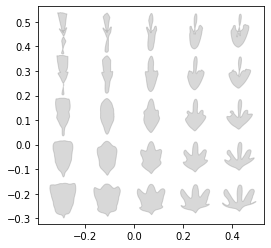

In [19]:
# scale, determined by checking, to prevent shape overlap
scale = 0.8

# padding on each side of PC to add extra space to see morphospace
PC1_pad = 0.1
PC2_pad = 0.1

# number of intervals to divide each PC axis
num_intervals = 5 

Morphospace(scale, PC1_pad, PC2_pad, num_intervals, PCs)

### Calculate shape descriptors

To measure lobing we will use circularity. We are currently using the circularity less used, which puts the area in the numerator and the perimeter in the denominator, so that 1 is a perfect circle and 0 deviates from that, but we can always switch these. Aspect ratio is calculated as width/length, and we use the fact that our leaves are oriented upright to simply take the min and max width and length values of leaves. We can figure out how to calculate solidity if needed as well, but maybe circularity is enough.

In [20]:
# Create a function to calculate circularity

# input: a 2D array of points for a polygon
# output: circularity value, calculated as (4*pi*area)/perimeter**2
# where 1 is a perfect circle and down to 0 for non-circular shapes

def Circularity(shape_arr):
    
    lines = np.hstack([shape_arr,np.roll(shape_arr,-1,axis=0)])
    area = 0.5*abs(sum(x1*y2-x2*y1 for x1,y1,x2,y2 in lines))
    
    distance = np.cumsum(np.sqrt( np.ediff1d(shape_arr[:,0], to_begin=0)**2 + np.ediff1d(shape_arr[:,1], to_begin=0)**2 ))
    perimeter = distance[-1]
    
    circularity = (4*math.pi*area)/perimeter**2
    
    return circularity
    
    

#### Calculate circularity and aspect ratio values for all leaves

In [21]:
# a list to store circularity values
circularity_vals = []

# a list to store aspect ratio values (width divided by length)
aspect_ratio_vals = []

# for each Procrustes-adjusted shape
for i in range(np.shape(proc_arr)[0]):
    
    # select current shape
    curr_shape = proc_arr[i] 
    
    # calculate circularity and append to list
    circularity_vals.append(Circularity(curr_shape))
    
    # calculate length, width, and aspect ratio
    length = np.max(curr_shape[:,1]) - np.min(curr_shape[:,1])
    width = np.max(curr_shape[:,0]) - np.min(curr_shape[:,0])
    aspect_ratio_vals.append(width/length)


#### Create a pandas dataframe to use seaborn, using a dictionary with the keys as column names and the values the data

In [22]:
df = pd.DataFrame({"PC1":PCs[:,0], "PC2":PCs[:,1], "circ":circularity_vals, "ar":aspect_ratio_vals})

#### Create a PC morphospace plot, points colored by circularity

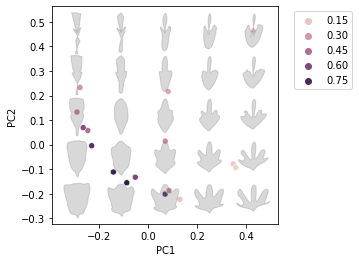

In [23]:
# scatterplot of PC values, colored by circularity (using hue in seaborn)
sns.scatterplot(data=df, x="PC1", y="PC2", hue="circ")

# scale, determined by checking, to prevent shape overlap
scale = 0.8

# padding on each side of PC to add extra space to see morphospace
PC1_pad = 0.1
PC2_pad = 0.1

# number of intervals to divide each PC axis
num_intervals = 5 

# use the morphospace function to create morphospace
Morphospace(scale, PC1_pad, PC2_pad, num_intervals, PCs)

# place the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#### Create a PC morphospace plot, points colored by aspect ratio

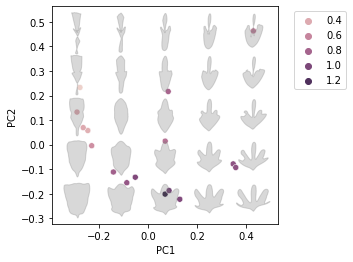

In [24]:
# scatterplot of PC values, colored by aspect ratio (using hue in seaborn)
sns.scatterplot(data=df, x="PC1", y="PC2", hue="ar")

# scale, determined by checking, to prevent shape overlap
scale = 0.8

# padding on each side of PC to add extra space to see morphospace
PC1_pad = 0.1
PC2_pad = 0.1

# number of intervals to divide each PC axis
num_intervals = 5 

# use the morphospace function to create morphospace
Morphospace(scale, PC1_pad, PC2_pad, num_intervals, PCs)

# place the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

### Find closest matches to archetypal leaves

For a given leaf, find its closest match to a set of archetypepal leaves using Procrustes distance

In [25]:
# a list of the shapes to compare to
# in this case, I will use A1, B1, C1, and D1
# which are indices 0, 4, 8, and 12

archetypes = [proc_arr[0], proc_arr[1], proc_arr[2], proc_arr[3]]

# create a list of names to refer to them as
names = ["A1", "B1", "C1", "D1"]

# create a list to store the closest matched archetype to each leaf
closest_matches = []

# for each shape
for i in range(len(shapes)):
    
    # select the current shape
    curr_shape = proc_arr[i]
    
    # create a list of distances of the current shape to each archetype
    archetype_dist = []
    
    # for each archetype
    for j in range(len(names)):
        
        # calculate Procrustes distance between archetype and current shape
        s1, s2, distance = procrustes(archetypes[j], curr_shape) 
        
        # append distance to list of distances
        archetype_dist.append(distance)
    
    # find index of closest archetype to current leaf
    archetype_index = archetype_dist.index(min(archetype_dist))
    
    # get name of closest archetype to current leaf using the index
    archetype_name = names[archetype_index]
    
    # append the closest match to list
    closest_matches.append(archetype_name)


In [26]:
# to the dataframe that already has PC1, PC2, circularity, and aspect ratio, and best_match

df["best_match"] = closest_matches

df.head()

,PC1,PC2,circ,ar,best_match
0,-0.228604,-0.004367,0.716439,0.545009,A1
1,-0.140119,-0.111488,0.792252,0.820509,B1
2,-0.050986,-0.132698,0.602623,0.984299,C1
3,-0.288411,0.132674,0.412380,0.437888,D1
4,0.070833,0.014391,0.333575,0.711992,B1


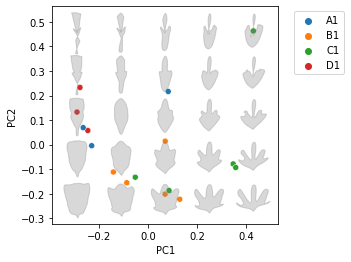

In [27]:
# Plot the data and color by best match

# scatterplot of PC values, colored by best_match (using hue in seaborn)
sns.scatterplot(data=df, x="PC1", y="PC2", hue="best_match")

# scale, determined by checking, to prevent shape overlap
scale = 0.8

# padding on each side of PC to add extra space to see morphospace
PC1_pad = 0.1
PC2_pad = 0.1

# number of intervals to divide each PC axis
num_intervals = 5 

# use the morphospace function to create morphospace
Morphospace(scale, PC1_pad, PC2_pad, num_intervals, PCs)

# place the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')